In [1]:
import os
import json
import sys
import random
sys.path.insert(0, '.')
import tensorflow as tf
import numpy as np
from models import grid_nets, im_nets, model_vlsm
from ops import conv_rnns
from mvnet import MVNet
from utils import Bunch, get_session_config

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Get pretrained models
!sh get_models.sh

File already exists. Checking md5...
Checksum is incorrect. Need to download again.
--2019-02-14 15:05:12--  https://www.dropbox.com/s/q14sfozef6g3gcx/models_lsm_v1_small.tar
Resolving web.ucsd.edu (web.ucsd.edu)... 132.239.1.231, 132.239.1.230
Connecting to web.ucsd.edu (web.ucsd.edu)|132.239.1.231|:3128... connected.
Proxy request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/q14sfozef6g3gcx/models_lsm_v1_small.tar [following]
--2019-02-14 15:05:12--  https://www.dropbox.com/s/raw/q14sfozef6g3gcx/models_lsm_v1_small.tar
Reusing existing connection to www.dropbox.com:443.
Proxy request sent, awaiting response... 302 Found
Location: https://ucd938503b6f2eb20829ca54c929.dl.dropboxusercontent.com/cd/0/inline/AbX4lX4bY57NeFEpgcaRNqktv8nipAE0AgaPWn8cMxjoD9IuDcs8GDWMlAg37Br0Bi4x--GJ4qo_puFKx10zOHKw9AbSmzU3GAoIKksQY1I5WA/file# [following]
--2019-02-14 15:05:13--  https://ucd938503b6f2eb20829ca54c929.dl.dropboxusercontent.com/cd/0/inline/AbX4lX4bY57NeFEpgcaRNqktv8nipAE0Aga

In [3]:
# Get sample data
!sh download_sample.sh
SAMPLE_DIR = os.path.join('data', 'shapenet_sample')

File already exists. Checking md5...
Checksum is correct. No need to download.


In [4]:
im_dir = os.path.join(SAMPLE_DIR, 'renders')
log_dir = os.path.join('models_lsm_v1/vlsm-release/train')
with open(os.path.join(log_dir, 'args.json'), 'r') as f:
    args = json.load(f)
args = Bunch(args)

In [5]:
# Setup TF graph and initialize VLSM model
tf.reset_default_graph()

# Change the ims_per_model to run on different number of views
bs, ims_per_model = 1, 4

ckpt = 'mvnet-100000'
net = MVNet(vmin=-0.5, vmax=0.5, vox_bs=bs,
          im_bs=ims_per_model, grid_size=args.nvox,
          im_h=args.im_h, im_w=args.im_w,
          norm=args.norm, mode="TEST")

net = model_vlsm(net, im_nets[args.im_net], grid_nets[args.grid_net],
                     conv_rnns[args.rnn])
vars_restore = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='MVNet')
sess = tf.InteractiveSession(config=get_session_config())
saver = tf.train.Saver(var_list=vars_restore)
saver.restore(sess, os.path.join(log_dir, ckpt))

INFO:tensorflow:Restoring parameters from models_lsm_v1/vlsm-release/train/mvnet-100000


In [6]:
from shapenet import ShapeNet
# Read data
dset = ShapeNet(im_dir=im_dir, split_file=os.path.join(SAMPLE_DIR, 'splits_sample.json'), rng_seed=1)
test_mids = dset.get_smids('test')

In [10]:
# Run the last three cells to run on different inputs
rand_sid, rand_mid = random.choice(test_mids) # Select model to test
rand_views = np.random.choice(dset.num_renders, size=(net.im_batch, ), replace=False) # Select views of model to test

# Load images and cameras
ims = dset.load_func['im'](rand_sid, rand_mid, rand_views)
ims = np.expand_dims(ims, 0)
R = dset.load_func['R'](rand_sid, rand_mid, rand_views)
R = np.expand_dims(R, 0)
K = dset.load_func['K'](rand_sid, rand_mid, rand_views)
K = np.expand_dims(K, 0)

In [11]:
# Run VLSM
feed_dict = {net.K: K, net.Rcam: R, net.ims: ims}
pred_voxels = sess.run(net.prob_vox, feed_dict=feed_dict)

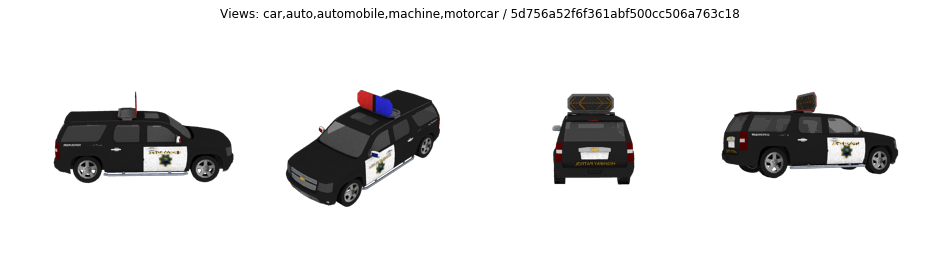

In [12]:
from vis_utils import image_grid, voxels2pts, plot_points, voxel_grid
from IPython.display import display
from IPython.core.display import HTML

# Visualize views
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16, 10))
plt.imshow(image_grid(ims))
plt.title('Views: {:s} / {:s}'.format(dset.splits[rand_sid]['name'], rand_mid))
plt.axis('off')
plt.show()

# Visualize predictions - displays voxel predictions after {1, 2, 3, ..., ims_per_model} views
# Feel free to play around with the 3D models!
pts, clr = voxel_grid(pred_voxels, thresh=0.4, cmap="plasma")
display(plot_points(pts, colors=clr, size=0.7, title="Voxel Predictions"))

# Center outputs
HTML("""
<style>
.output {
    align-items: center;
}
</style>
""")